In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import time
from collections import Counter

In [2]:
# Set seed untuk reproduksibilitas
SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [3]:
# Cek ketersediaan GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Load dataset IMDb dari TensorFlow
def load_imdb_data_from_tensorflow():
    print("Loading IMDb dataset from TensorFlow...")
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=20000)

    # Dapatkan word index
    word_index = tf.keras.datasets.imdb.get_word_index()

    # Balikkan word index untuk mendapatkan decode function
    reverse_word_index = {value: key for key, value in word_index.items()}
    # Perhatikan ada offset khusus
    decode = lambda indices: ' '.join([reverse_word_index.get(i - 3, '?') for i in indices])

    # Decode data menjadi teks
    train_texts = [decode(x) for x in x_train]
    test_texts = [decode(x) for x in x_test]

    # Buat dataset dalam format (text, label)
    train_data = [(text, label) for text, label in zip(train_texts, y_train)]
    test_data = [(text, label) for text, label in zip(test_texts, y_test)]

    # Buat vocabulary
    # Pertama, kumpulkan semua kata unik
    all_words = []
    for text, _ in train_data:
        all_words.extend(text.split())

    # Hitung frekuensi kata
    word_counts = Counter(all_words)

    # Buat vocabulary dengan kata-kata yang muncul lebih dari 5 kali
    vocab = {word: idx + 2 for idx, (word, count) in enumerate(word_counts.items()) if count >= 5}
    vocab['<pad>'] = 0
    vocab['<unk>'] = 1

    return train_data, test_data, vocab, len(vocab)

In [5]:
# Load data dari TensorFlow
train_data, test_data, vocab, vocab_size = load_imdb_data_from_tensorflow()
print(f"Train data size: {len(train_data)}, Test data size: {len(test_data)}")
print(f"Vocabulary size: {vocab_size}")

Loading IMDb dataset from TensorFlow...
Train data size: 25000, Test data size: 25000
Vocabulary size: 19998


In [6]:
# Split training data into train and validation
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=SEED)
print(f"Train set: {len(train_data)}, Validation set: {len(val_data)}")

Train set: 22500, Validation set: 2500


In [7]:
# Tokenizer function
def tokenize(text):
    return text.lower().split()

In [8]:
# Custom Dataset class
class IMDbDataset(Dataset):
    def __init__(self, data, vocab, max_len=None):
        self.data = data
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, label = self.data[idx]
        tokens = tokenize(text)
        if self.max_len:
            tokens = tokens[:self.max_len]
        indices = [self.vocab.get(token, self.vocab['<unk>']) for token in tokens]
        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.float)

In [9]:
# Function untuk padding
def collate_batch(batch):
    text_list, label_list = [], []
    for (_text, _label) in batch:
        text_list.append(_text)
        label_list.append(_label)

    # Padding
    text_padded = nn.utils.rnn.pad_sequence(text_list, batch_first=True, padding_value=vocab['<pad>'])
    label_list = torch.stack(label_list)
    return text_padded, label_list

In [10]:
# Buat dataset dan dataloader
def create_dataloaders(batch_size=32, max_len=None):
    train_dataset = IMDbDataset(train_data, vocab, max_len)
    val_dataset = IMDbDataset(val_data, vocab, max_len)
    test_dataset = IMDbDataset(test_data, vocab, max_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_batch)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_batch)

    return train_loader, val_loader, test_loader

In [11]:
# Bidirectional RNN model
class BidirectionalRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout, rnn_type='lstm'):
        super(BidirectionalRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab['<pad>'])

        if rnn_type.lower() == 'lstm':
            self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers, bidirectional=True, dropout=dropout if num_layers > 1 else 0, batch_first=True)
        elif rnn_type.lower() == 'gru':
            self.rnn = nn.GRU(embed_dim, hidden_dim, num_layers, bidirectional=True, dropout=dropout if num_layers > 1 else 0, batch_first=True)
        else:
            raise ValueError("rnn_type must be either 'lstm' or 'gru'")

        self.fc = nn.Linear(hidden_dim * 2, 1)  # *2 karena bidirectional
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text: [batch_size, seq_len]
        embedded = self.dropout(self.embedding(text))  # [batch_size, seq_len, embed_dim]

        # Bidirectional RNN
        if isinstance(self.rnn, nn.LSTM):
            output, (hidden, _) = self.rnn(embedded)
        else:  # GRU
            output, hidden = self.rnn(embedded)

        # Concat forward and backward last hidden states
        # hidden: [num_layers * 2, batch_size, hidden_dim]
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  # [batch_size, hidden_dim * 2]
        hidden = self.dropout(hidden)

        # Pass through linear layer
        return torch.sigmoid(self.fc(hidden)).squeeze(1)

In [12]:
# Training function
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    all_preds = []
    all_labels = []

    for batch in iterator:
        text, labels = batch
        text, labels = text.to(device), labels.to(device)

        optimizer.zero_grad()
        predictions = model(text)

        loss = criterion(predictions, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        epoch_loss += loss.item()

        # Store predictions and labels for metrics calculation
        pred_binary = (predictions >= 0.5).float()
        all_preds.extend(pred_binary.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Calculate batch accuracy
        batch_acc = ((pred_binary == labels).float().sum() / len(labels)).item()
        epoch_acc += batch_acc

    # Calculate metrics
    epoch_acc = sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    return epoch_loss / len(iterator), epoch_acc, precision, recall, f1

In [13]:
# Evaluation function
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    all_preds = []
    all_pred_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in iterator:
            text, labels = batch
            text, labels = text.to(device), labels.to(device)

            predictions = model(text)
            loss = criterion(predictions, labels)

            epoch_loss += loss.item()

            # Store predictions and labels for metrics calculation
            pred_binary = (predictions >= 0.5).float()
            all_preds.extend(pred_binary.cpu().numpy())
            all_pred_probs.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    epoch_acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    f1 = f1_score(all_labels, all_preds, zero_division=0)

    try:
        auc = roc_auc_score(all_labels, all_pred_probs)
    except:
        auc = 0.0

    return epoch_loss / len(iterator), epoch_acc, precision, recall, f1, auc, all_preds, all_labels

In [14]:
# Fungsi untuk melatih model dan memvisualisasikan hasil
def run_training(model, train_loader, val_loader, optimizer, criterion, n_epochs=5):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(n_epochs):
        start_time = time.time()

        # Training
        train_loss, train_acc, train_prec, train_rec, train_f1 = train(model, train_loader, optimizer, criterion)
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        val_loss, val_acc, val_prec, val_rec, val_f1, val_auc, _, _ = evaluate(model, val_loader, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        end_time = time.time()
        epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

        # Save model if validation loss is improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best-bidir-rnn-model.pt')

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs:.2f}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\tVal. Loss: {val_loss:.3f} | Val. Acc: {val_acc*100:.2f}%')
        print(f'\tPrecision: {val_prec:.3f} | Recall: {val_rec:.3f} | F1: {val_f1:.3f} | AUC: {val_auc:.3f}')

    # Visualize training progress
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.savefig('training_progress.png')
    plt.show()

    return train_losses, val_losses, train_accs, val_accs

In [15]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.show()

In [ ]:
# Function to plot ROC curve
def plot_roc_curve(y_true, y_pred_probs, title="ROC Curve"):
    from sklearn.metrics import roc_curve, auc
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.savefig(f'{title.lower().replace(" ", "_")}.png')
    plt.show()

    return roc_auc

In [17]:
# Hyperparameter tuning function
def hyperparameter_tuning():
    param_combinations = [
        # Format: [embed_dim, hidden_dim, num_layers, dropout, batch_size, lr, rnn_type]
        [100, 128, 2, 0.5, 64, 0.001, 'lstm'],
        [200, 128, 2, 0.5, 64, 0.001, 'lstm'],
        [200, 256, 2, 0.5, 64, 0.001, 'lstm'],
        [200, 256, 3, 0.5, 64, 0.001, 'lstm'],
        [200, 256, 2, 0.3, 64, 0.001, 'lstm'],
        [200, 256, 2, 0.5, 128, 0.001, 'lstm'],
        [200, 256, 2, 0.5, 64, 0.0005, 'lstm'],
        [200, 256, 2, 0.5, 64, 0.001, 'gru'],
    ]

    results = []

    for i, params in enumerate(param_combinations):
        embed_dim, hidden_dim, num_layers, dropout, batch_size, lr, rnn_type = params

        print(f"\nTuning combination {i+1}/{len(param_combinations)}:")
        print(f"embed_dim={embed_dim}, hidden_dim={hidden_dim}, num_layers={num_layers}, dropout={dropout}, batch_size={batch_size}, lr={lr}, rnn_type={rnn_type}")

        # Create dataloaders with current batch size
        train_loader, val_loader, test_loader = create_dataloaders(batch_size=batch_size, max_len=500)

        # Initialize model with current parameters
        model = BidirectionalRNN(vocab_size, embed_dim, hidden_dim, num_layers, dropout, rnn_type=rnn_type).to(device)

        # Initialize optimizer and criterion
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.BCELoss()

        # Train the model for a few epochs
        train_losses, val_losses, train_accs, val_accs = run_training(model, train_loader, val_loader, optimizer, criterion, n_epochs=3)

        # Evaluate the model on validation set
        val_loss, val_acc, val_prec, val_rec, val_f1, val_auc, _, _ = evaluate(model, val_loader, criterion)

        results.append({
            'embed_dim': embed_dim,
            'hidden_dim': hidden_dim,
            'num_layers': num_layers,
            'dropout': dropout,
            'batch_size': batch_size,
            'learning_rate': lr,
            'rnn_type': rnn_type,
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_prec': val_prec,
            'val_rec': val_rec,
            'val_f1': val_f1,
            'val_auc': val_auc
        })

        print(f"Validation metrics - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")

    # Find best combination based on validation F1 score
    results_df = pd.DataFrame(results)
    best_idx = results_df['val_f1'].idxmax()
    best_params = results_df.iloc[best_idx]

    print("\nBest hyperparameter combination:")
    print(f"embed_dim={best_params['embed_dim']}, hidden_dim={best_params['hidden_dim']}, num_layers={best_params['num_layers']}, dropout={best_params['dropout']}, batch_size={best_params['batch_size']}, lr={best_params['learning_rate']}, rnn_type={best_params['rnn_type']}")
    print(f"Validation metrics - Loss: {best_params['val_loss']:.4f}, Acc: {best_params['val_acc']:.4f}, F1: {best_params['val_f1']:.4f}, AUC: {best_params['val_auc']:.4f}")

    # Visualize hyperparameter tuning results
    plt.figure(figsize=(12, 8))

    # Plot validation accuracy for each combination
    plt.subplot(2, 2, 1)
    plt.bar(range(len(results)), [r['val_acc'] for r in results])
    plt.xticks(range(len(results)), [f"C{i+1}" for i in range(len(results))], rotation=45)
    plt.ylabel('Validation Accuracy')
    plt.title('Hyperparameter Combinations vs Accuracy')

    # Plot validation F1 score for each combination
    plt.subplot(2, 2, 2)
    plt.bar(range(len(results)), [r['val_f1'] for r in results])
    plt.xticks(range(len(results)), [f"C{i+1}" for i in range(len(results))], rotation=45)
    plt.ylabel('Validation F1 Score')
    plt.title('Hyperparameter Combinations vs F1 Score')

    # Plot validation AUC for each combination
    plt.subplot(2, 2, 3)
    plt.bar(range(len(results)), [r['val_auc'] for r in results])
    plt.xticks(range(len(results)), [f"C{i+1}" for i in range(len(results))], rotation=45)
    plt.ylabel('Validation AUC')
    plt.title('Hyperparameter Combinations vs AUC')

    # Plot validation loss for each combination
    plt.subplot(2, 2, 4)
    plt.bar(range(len(results)), [r['val_loss'] for r in results])
    plt.xticks(range(len(results)), [f"C{i+1}" for i in range(len(results))], rotation=45)
    plt.ylabel('Validation Loss')
    plt.title('Hyperparameter Combinations vs Loss')

    plt.tight_layout()
    plt.savefig('hyperparameter_tuning_results.png')
    plt.show()

    # Save results to CSV
    results_df.to_csv('hyperparameter_tuning_results.csv', index=False)

    return best_params

In [18]:
# Main function to run the entire pipeline
def main():
    print("Starting hyperparameter tuning...")
    best_params = hyperparameter_tuning()

    # Create dataloaders with the best batch size
    train_loader, val_loader, test_loader = create_dataloaders(batch_size=int(best_params['batch_size']), max_len=500)

    # Initialize the best model
    best_model = BidirectionalRNN(
        vocab_size,
        int(best_params['embed_dim']),
        int(best_params['hidden_dim']),
        int(best_params['num_layers']),
        best_params['dropout'],
        rnn_type=best_params['rnn_type']
    ).to(device)

    # Initialize optimizer and criterion
    optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
    criterion = nn.BCELoss()

    # Train the best model for more epochs
    print("\nTraining the best model with more epochs...")
    train_losses, val_losses, train_accs, val_accs = run_training(best_model, train_loader, val_loader, optimizer, criterion, n_epochs=10)

    # Load the best model
    best_model.load_state_dict(torch.load('best-bidir-rnn-model.pt'))

    # Evaluate on the test set
    test_loss, test_acc, test_prec, test_rec, test_f1, test_auc, test_preds, test_labels = evaluate(best_model, test_loader, criterion)

    print("\nTest performance:")
    print(f"\tLoss: {test_loss:.3f} | Accuracy: {test_acc*100:.2f}%")
    print(f"\tPrecision: {test_prec:.3f} | Recall: {test_rec:.3f}")
    print(f"\tF1 Score: {test_f1:.3f} | AUC: {test_auc:.3f}")

    # Plot confusion matrix
    plot_confusion_matrix(test_labels, test_preds, "Confusion Matrix - Test Set")

    # Plot ROC curve
    test_loss, test_acc, test_prec, test_rec, test_f1, test_auc, test_preds, test_labels = evaluate(best_model, test_loader, criterion)
    # Get prediction probabilities for ROC curve
    all_pred_probs = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            text, labels = batch
            text, labels = text.to(device), labels.to(device)
            predictions = best_model(text)
            all_pred_probs.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    plot_roc_curve(all_labels, all_pred_probs, "ROC Curve - Test Set")

    # Save final results
    results = {
        'test_loss': test_loss,
        'test_accuracy': test_acc,
        'test_precision': test_prec,
        'test_recall': test_rec,
        'test_f1': test_f1,
        'test_auc': test_auc,
        'best_params': {
            'embed_dim': int(best_params['embed_dim']),
            'hidden_dim': int(best_params['hidden_dim']),
            'num_layers': int(best_params['num_layers']),
            'dropout': best_params['dropout'],
            'batch_size': int(best_params['batch_size']),
            'learning_rate': best_params['learning_rate'],
            'rnn_type': best_params['rnn_type']
        }
    }

    # Save results to CSV
    pd.DataFrame([results]).to_csv('final_results.csv', index=False)
    print("\nResults saved to 'final_results.csv'")

    # Create visual summary of test results
    plt.figure(figsize=(10, 6))
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
    values = [test_acc, test_prec, test_rec, test_f1, test_auc]

    plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple', 'orange'])
    plt.ylim(0, 1.0)
    plt.title('Test Set Performance Metrics')
    plt.ylabel('Score')

    # Add value labels on top of bars
    for i, v in enumerate(values):
        plt.text(i, v + 0.02, f'{v:.3f}', ha='center')

    plt.tight_layout()
    plt.savefig('test_metrics_summary.png')
    plt.show()

Starting hyperparameter tuning...

Tuning combination 1/8:
embed_dim=100, hidden_dim=128, num_layers=2, dropout=0.5, batch_size=64, lr=0.001, rnn_type=lstm
Epoch: 01 | Time: 0.0m 24.00s
	Train Loss: 0.672 | Train Acc: 57.50%
	Val. Loss: 0.711 | Val. Acc: 59.68%
	Precision: 0.571 | Recall: 0.938 | F1: 0.710 | AUC: 0.686
Epoch: 02 | Time: 0.0m 23.03s
	Train Loss: 0.653 | Train Acc: 61.68%
	Val. Loss: 0.585 | Val. Acc: 69.96%
	Precision: 0.760 | Recall: 0.629 | F1: 0.688 | AUC: 0.762
Epoch: 03 | Time: 0.0m 22.78s
	Train Loss: 0.590 | Train Acc: 69.92%
	Val. Loss: 0.573 | Val. Acc: 72.92%
	Precision: 0.669 | Recall: 0.960 | F1: 0.789 | AUC: 0.809


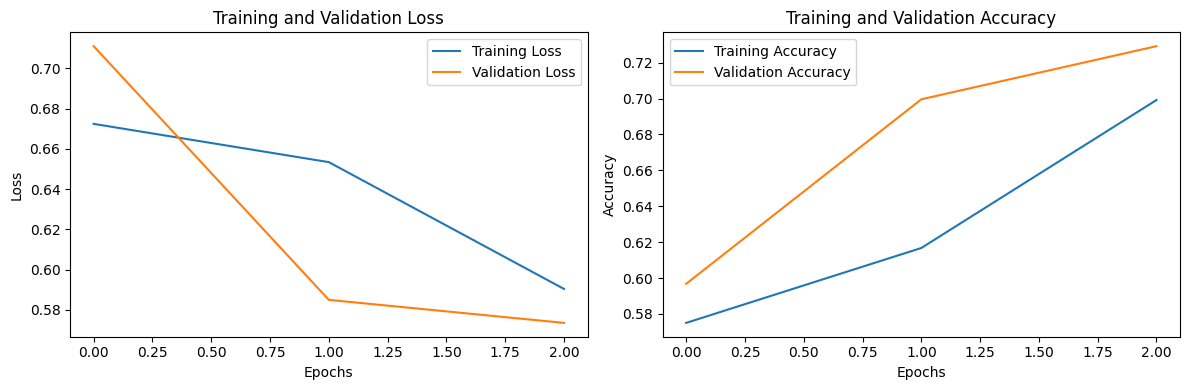

Validation metrics - Loss: 0.5735, Acc: 0.7292, F1: 0.7888, AUC: 0.8090

Tuning combination 2/8:
embed_dim=200, hidden_dim=128, num_layers=2, dropout=0.5, batch_size=64, lr=0.001, rnn_type=lstm
Epoch: 01 | Time: 0.0m 25.69s
	Train Loss: 0.674 | Train Acc: 57.64%
	Val. Loss: 0.619 | Val. Acc: 67.00%
	Precision: 0.689 | Recall: 0.680 | F1: 0.685 | AUC: 0.729
Epoch: 02 | Time: 0.0m 26.51s
	Train Loss: 0.597 | Train Acc: 68.18%
	Val. Loss: 0.569 | Val. Acc: 72.32%
	Precision: 0.809 | Recall: 0.621 | F1: 0.703 | AUC: 0.808
Epoch: 03 | Time: 0.0m 27.73s
	Train Loss: 0.539 | Train Acc: 74.32%
	Val. Loss: 0.719 | Val. Acc: 73.16%
	Precision: 0.703 | Recall: 0.848 | F1: 0.769 | AUC: 0.788


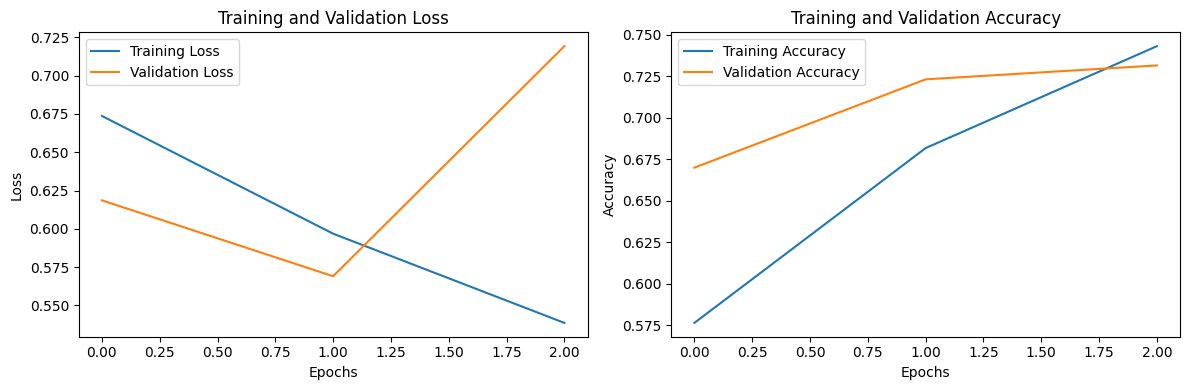

Validation metrics - Loss: 0.7193, Acc: 0.7316, F1: 0.7690, AUC: 0.7883

Tuning combination 3/8:
embed_dim=200, hidden_dim=256, num_layers=2, dropout=0.5, batch_size=64, lr=0.001, rnn_type=lstm
Epoch: 01 | Time: 1.0m 14.83s
	Train Loss: 0.684 | Train Acc: 54.36%
	Val. Loss: 0.685 | Val. Acc: 60.28%
	Precision: 0.620 | Recall: 0.637 | F1: 0.628 | AUC: 0.636
Epoch: 02 | Time: 1.0m 15.98s
	Train Loss: 0.670 | Train Acc: 58.34%
	Val. Loss: 0.666 | Val. Acc: 61.40%
	Precision: 0.579 | Recall: 0.983 | F1: 0.728 | AUC: 0.742
Epoch: 03 | Time: 1.0m 16.19s
	Train Loss: 0.542 | Train Acc: 73.19%
	Val. Loss: 0.691 | Val. Acc: 74.36%
	Precision: 0.696 | Recall: 0.913 | F1: 0.789 | AUC: 0.828


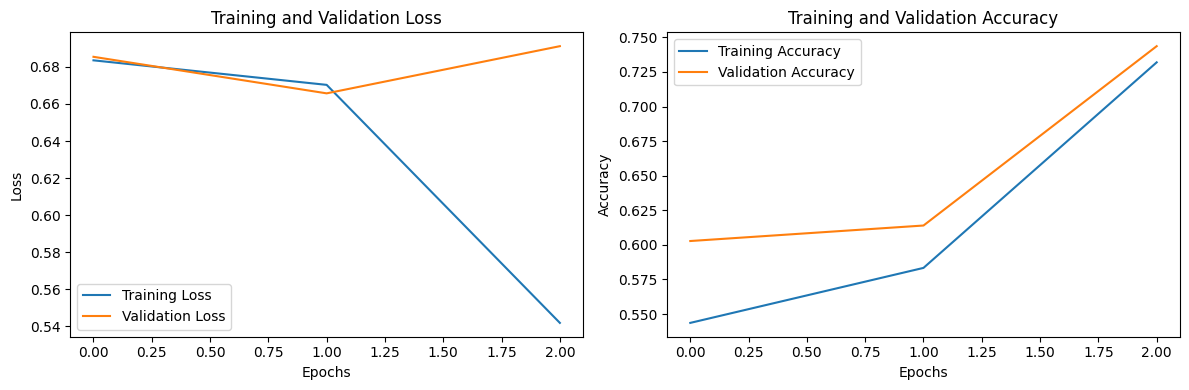

Validation metrics - Loss: 0.6912, Acc: 0.7436, F1: 0.7895, AUC: 0.8284

Tuning combination 4/8:
embed_dim=200, hidden_dim=256, num_layers=3, dropout=0.5, batch_size=64, lr=0.001, rnn_type=lstm
Epoch: 01 | Time: 2.0m 0.02s
	Train Loss: 0.676 | Train Acc: 56.76%
	Val. Loss: 0.703 | Val. Acc: 64.64%
	Precision: 0.617 | Recall: 0.869 | F1: 0.721 | AUC: 0.659
Epoch: 02 | Time: 2.0m 1.93s
	Train Loss: 0.608 | Train Acc: 67.72%
	Val. Loss: 0.490 | Val. Acc: 77.36%
	Precision: 0.806 | Recall: 0.752 | F1: 0.778 | AUC: 0.853
Epoch: 03 | Time: 2.0m 3.50s
	Train Loss: 0.468 | Train Acc: 78.94%
	Val. Loss: 0.453 | Val. Acc: 79.08%
	Precision: 0.726 | Recall: 0.969 | F1: 0.830 | AUC: 0.910


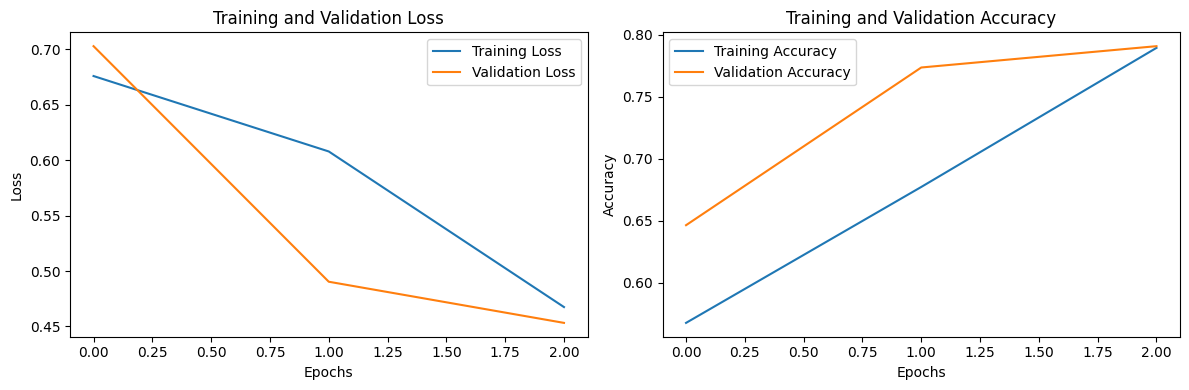

Validation metrics - Loss: 0.4532, Acc: 0.7908, F1: 0.8299, AUC: 0.9102

Tuning combination 5/8:
embed_dim=200, hidden_dim=256, num_layers=2, dropout=0.3, batch_size=64, lr=0.001, rnn_type=lstm
Epoch: 01 | Time: 1.0m 15.95s
	Train Loss: 0.686 | Train Acc: 53.92%
	Val. Loss: 0.688 | Val. Acc: 52.72%
	Precision: 0.639 | Recall: 0.236 | F1: 0.345 | AUC: 0.600
Epoch: 02 | Time: 1.0m 15.84s
	Train Loss: 0.636 | Train Acc: 63.88%
	Val. Loss: 0.556 | Val. Acc: 72.92%
	Precision: 0.783 | Recall: 0.672 | F1: 0.723 | AUC: 0.804
Epoch: 03 | Time: 1.0m 16.34s
	Train Loss: 0.481 | Train Acc: 77.73%
	Val. Loss: 0.392 | Val. Acc: 82.52%
	Precision: 0.790 | Recall: 0.910 | F1: 0.846 | AUC: 0.909


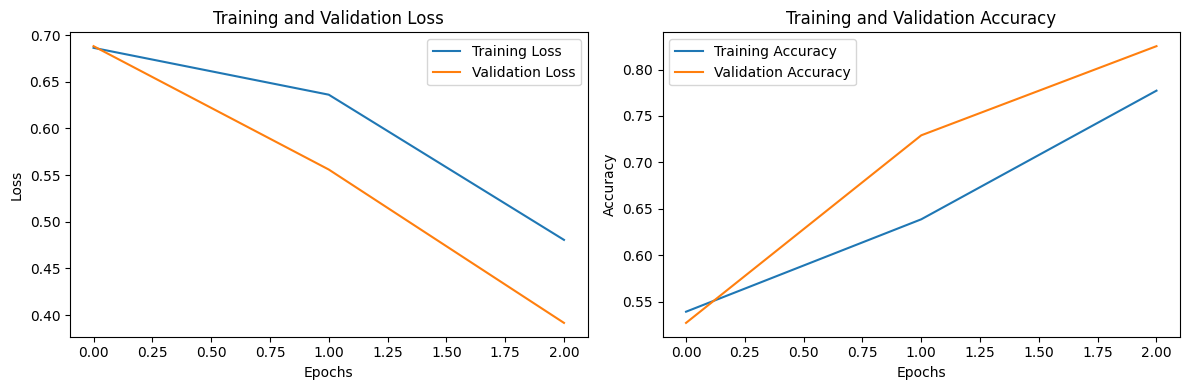

Validation metrics - Loss: 0.3917, Acc: 0.8252, F1: 0.8457, AUC: 0.9094

Tuning combination 6/8:
embed_dim=200, hidden_dim=256, num_layers=2, dropout=0.5, batch_size=128, lr=0.001, rnn_type=lstm
Epoch: 01 | Time: 1.0m 7.40s
	Train Loss: 0.669 | Train Acc: 58.76%
	Val. Loss: 0.628 | Val. Acc: 66.56%
	Precision: 0.672 | Recall: 0.714 | F1: 0.692 | AUC: 0.723
Epoch: 02 | Time: 1.0m 8.10s
	Train Loss: 0.615 | Train Acc: 67.10%
	Val. Loss: 0.557 | Val. Acc: 71.88%
	Precision: 0.717 | Recall: 0.771 | F1: 0.743 | AUC: 0.795
Epoch: 03 | Time: 1.0m 8.71s
	Train Loss: 0.542 | Train Acc: 73.99%
	Val. Loss: 0.580 | Val. Acc: 76.36%
	Precision: 0.786 | Recall: 0.758 | F1: 0.772 | AUC: 0.826


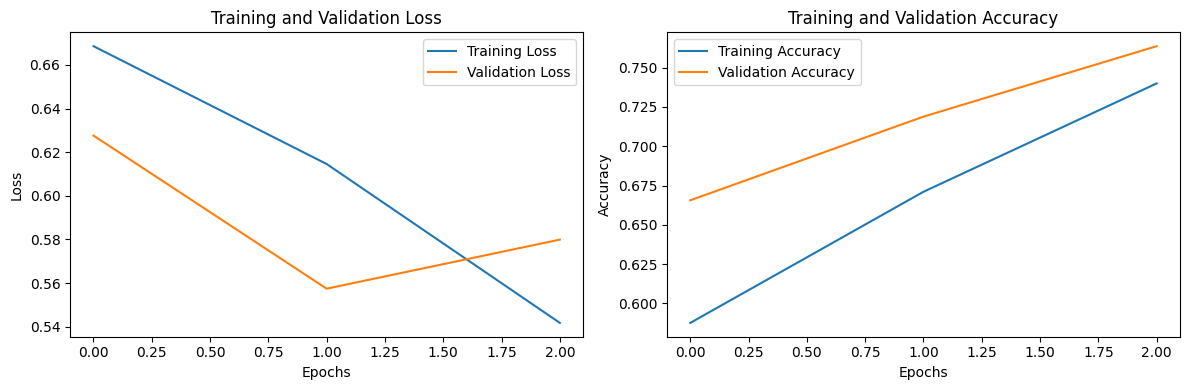

Validation metrics - Loss: 0.5799, Acc: 0.7636, F1: 0.7716, AUC: 0.8258

Tuning combination 7/8:
embed_dim=200, hidden_dim=256, num_layers=2, dropout=0.5, batch_size=64, lr=0.0005, rnn_type=lstm
Epoch: 01 | Time: 1.0m 14.26s
	Train Loss: 0.679 | Train Acc: 56.86%
	Val. Loss: 0.644 | Val. Acc: 63.80%
	Precision: 0.604 | Recall: 0.906 | F1: 0.725 | AUC: 0.708
Epoch: 02 | Time: 1.0m 14.65s
	Train Loss: 0.622 | Train Acc: 65.82%
	Val. Loss: 0.556 | Val. Acc: 72.68%
	Precision: 0.700 | Recall: 0.841 | F1: 0.764 | AUC: 0.790
Epoch: 03 | Time: 1.0m 15.01s
	Train Loss: 0.553 | Train Acc: 72.60%
	Val. Loss: 0.511 | Val. Acc: 76.48%
	Precision: 0.781 | Recall: 0.768 | F1: 0.775 | AUC: 0.827


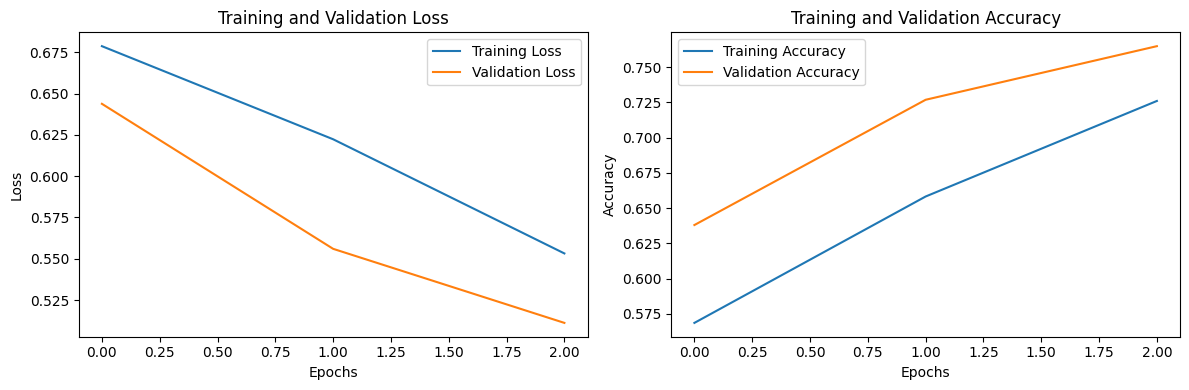

Validation metrics - Loss: 0.5112, Acc: 0.7648, F1: 0.7749, AUC: 0.8266

Tuning combination 8/8:
embed_dim=200, hidden_dim=256, num_layers=2, dropout=0.5, batch_size=64, lr=0.001, rnn_type=gru
Epoch: 01 | Time: 0.0m 59.08s
	Train Loss: 0.649 | Train Acc: 61.32%
	Val. Loss: 0.519 | Val. Acc: 75.48%
	Precision: 0.765 | Recall: 0.771 | F1: 0.768 | AUC: 0.833
Epoch: 02 | Time: 0.0m 59.11s
	Train Loss: 0.443 | Train Acc: 79.64%
	Val. Loss: 0.356 | Val. Acc: 85.12%
	Precision: 0.815 | Recall: 0.929 | F1: 0.868 | AUC: 0.934
Epoch: 03 | Time: 0.0m 59.06s
	Train Loss: 0.314 | Train Acc: 86.57%
	Val. Loss: 0.332 | Val. Acc: 88.00%
	Precision: 0.874 | Recall: 0.902 | F1: 0.888 | AUC: 0.951


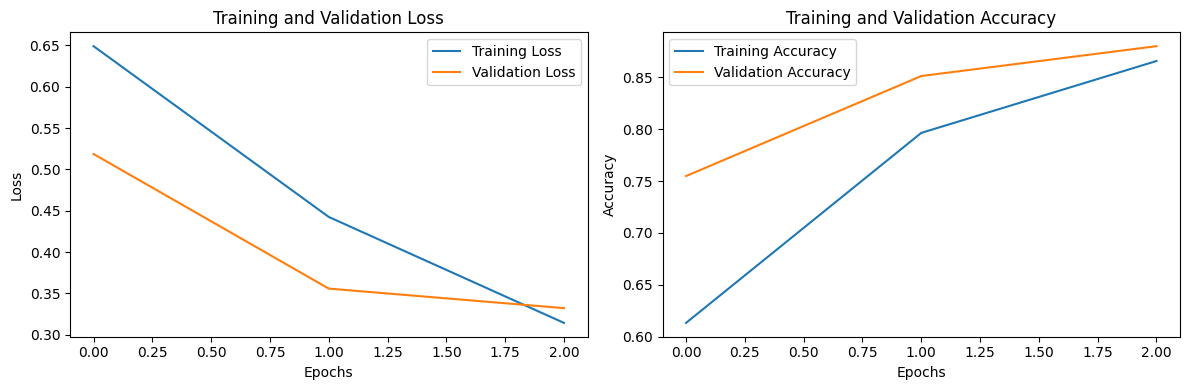

Validation metrics - Loss: 0.3322, Acc: 0.8800, F1: 0.8879, AUC: 0.9509

Best hyperparameter combination:
embed_dim=200, hidden_dim=256, num_layers=2, dropout=0.5, batch_size=64, lr=0.001, rnn_type=gru
Validation metrics - Loss: 0.3322, Acc: 0.8800, F1: 0.8879, AUC: 0.9509


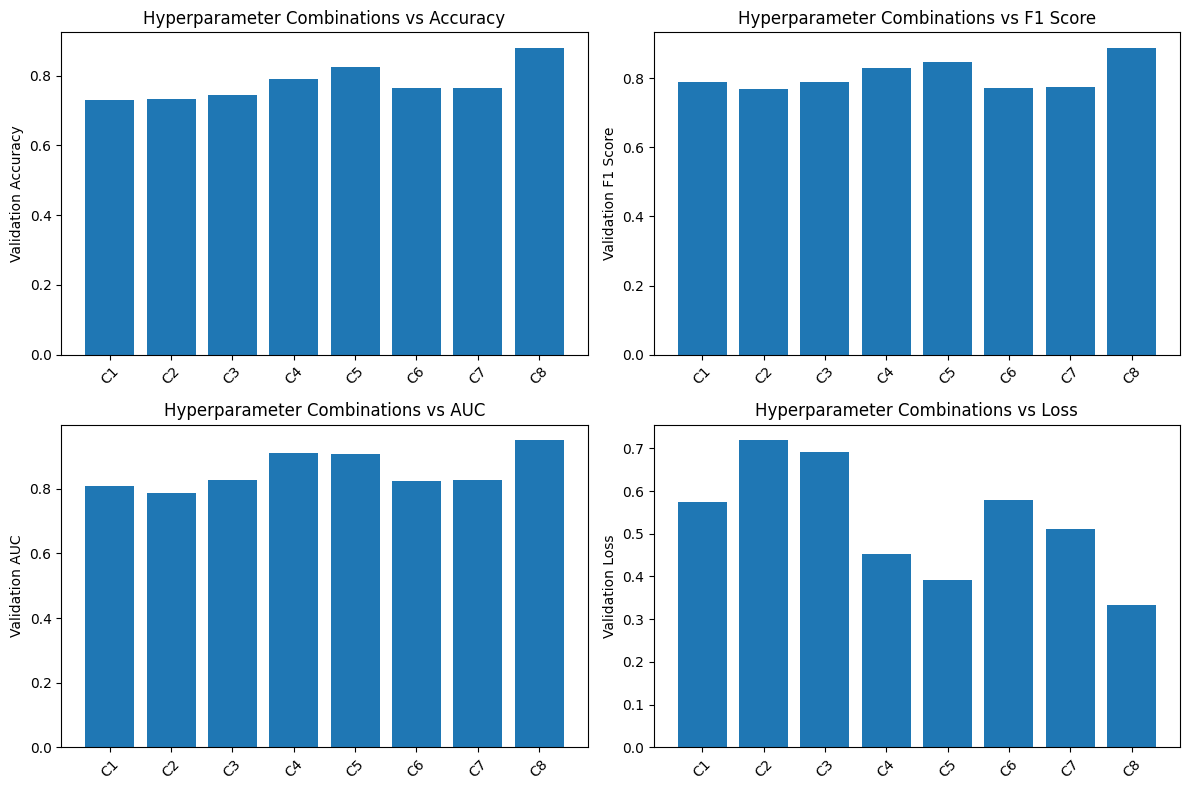


Training the best model with more epochs...
Epoch: 01 | Time: 0.0m 59.04s
	Train Loss: 0.664 | Train Acc: 60.02%
	Val. Loss: 0.656 | Val. Acc: 68.48%
	Precision: 0.802 | Recall: 0.533 | F1: 0.641 | AUC: 0.778
Epoch: 02 | Time: 0.0m 59.69s
	Train Loss: 0.520 | Train Acc: 74.38%
	Val. Loss: 0.383 | Val. Acc: 82.92%
	Precision: 0.797 | Recall: 0.907 | F1: 0.848 | AUC: 0.915
Epoch: 03 | Time: 0.0m 59.46s
	Train Loss: 0.349 | Train Acc: 84.70%
	Val. Loss: 0.306 | Val. Acc: 88.24%
	Precision: 0.879 | Recall: 0.901 | F1: 0.890 | AUC: 0.948
Epoch: 04 | Time: 0.0m 59.67s
	Train Loss: 0.280 | Train Acc: 88.44%
	Val. Loss: 0.297 | Val. Acc: 89.20%
	Precision: 0.875 | Recall: 0.928 | F1: 0.901 | AUC: 0.956
Epoch: 05 | Time: 0.0m 59.77s
	Train Loss: 0.233 | Train Acc: 90.69%
	Val. Loss: 0.288 | Val. Acc: 89.48%
	Precision: 0.924 | Recall: 0.872 | F1: 0.897 | AUC: 0.959
Epoch: 06 | Time: 0.0m 59.79s
	Train Loss: 0.200 | Train Acc: 92.14%
	Val. Loss: 0.305 | Val. Acc: 89.64%
	Precision: 0.881 | Reca

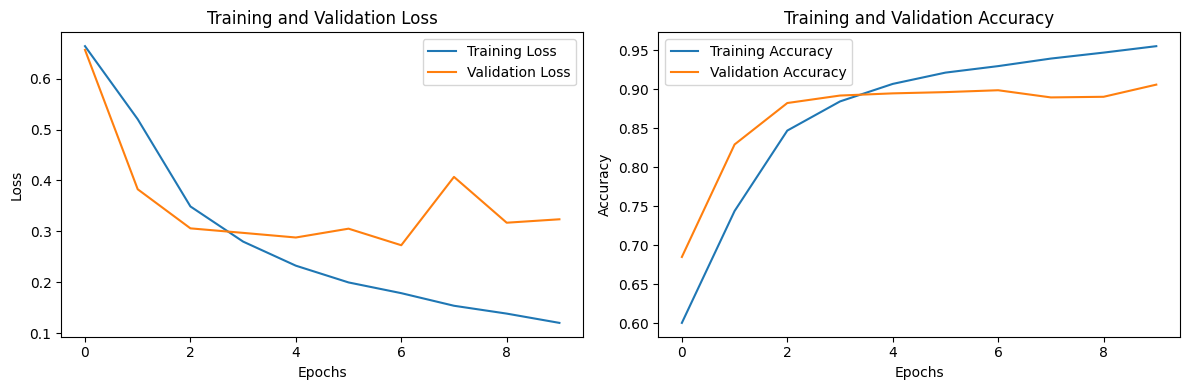


Test performance:
	Loss: 0.258 | Accuracy: 90.25%
	Precision: 0.909 | Recall: 0.894
	F1 Score: 0.902 | AUC: 0.965


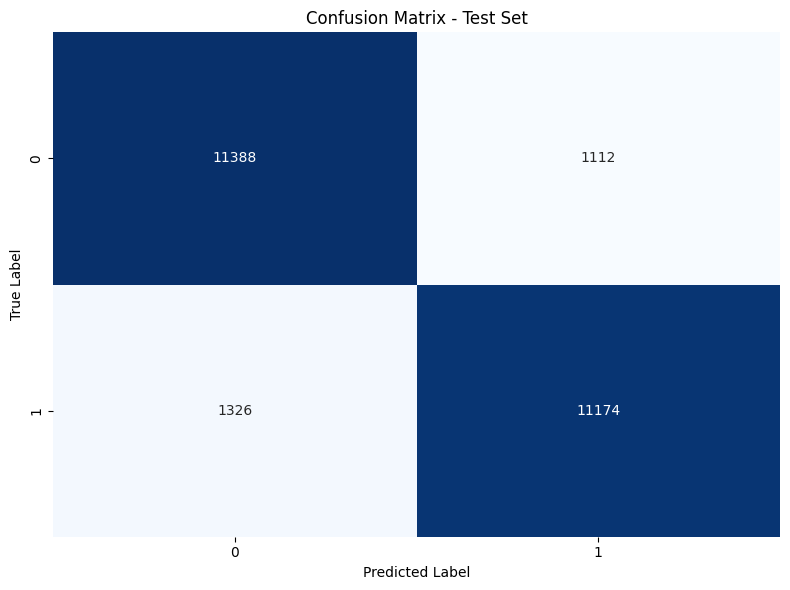

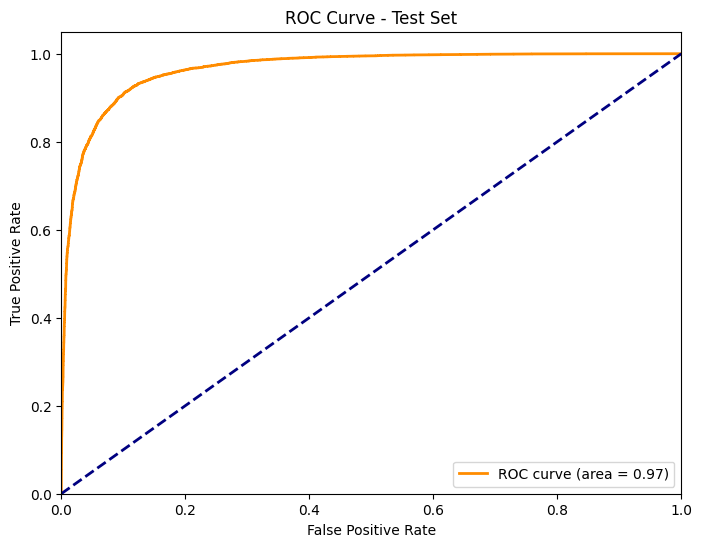


Results saved to 'final_results.csv'


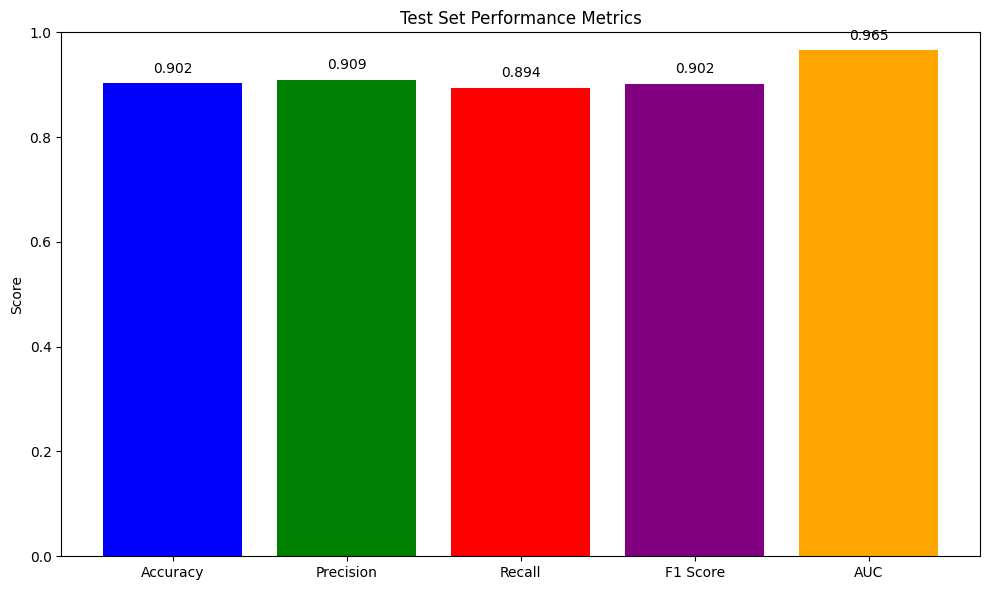

In [19]:
if __name__ == "__main__":
    main()